In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os,cv2
from PIL import Image
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [31]:
imagePaths=list(paths.list_images('dataset'))
data=[]
labels=[]
for x in imagePaths:
    label=x.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(x,target_size=(150,150))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)
data_new=np.array(data,dtype="float32")
labels=np.array(labels)
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [32]:
X_train,X_test,y_train,y_test=train_test_split(data_new,labels,test_size=0.15,stratify=labels,random_state=40)

In [4]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [5]:
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_shape=(150,150,3))
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(3,3))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)
model=Model(inputs=baseModel.input,outputs=headModel)
for layer in baseModel.layers:
    layer.trainable=False

In [6]:
checkpoint = ModelCheckpoint(filepath='best_weights_transfer_imagenet_mobilenetv2.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [7]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
model.fit(aug.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)/32,validation_steps=len(X_test)/32,validation_data=(X_test,y_test),epochs=20,callbacks=[checkpoint, lr_reduce])

Epoch 1/20
155/155 [==============================] - 114s 699ms/step - loss: 0.3485 - accuracy: 0.8583 - val_loss: 0.2041 - val_accuracy: 0.9247
Epoch 2/20
155/155 [==============================] - 106s 685ms/step - loss: 0.2690 - accuracy: 0.8922 - val_loss: 0.1865 - val_accuracy: 0.9292
Epoch 3/20
155/155 [==============================] - 106s 686ms/step - loss: 0.2515 - accuracy: 0.8938 - val_loss: 0.1776 - val_accuracy: 0.9326

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/20
155/155 [==============================] - 106s 683ms/step - loss: 0.2204 - accuracy: 0.9170 - val_loss: 0.1834 - val_accuracy: 0.9281
Epoch 5/20
155/155 [==============================] - 106s 680ms/step - loss: 0.2154 - accuracy: 0.9178 - val_loss: 0.1895 - val_accuracy: 0.9258

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/20
155/155 [==============================] - 106s 680ms/step - loss: 0.2214 - accuracy: 0.9113 - va

In [9]:
model.save("detection.hdf5")

C:\Users\Tuhin Roy\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [3]:
model=load_model("detection.hdf5")

In [89]:
imagePathscheck=list(paths.list_images('val'))
datacheck=[]
labels=[]

for x in imagePathscheck:
    label=x.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(x,target_size=(150,150))
    image=img_to_array(image)
    image=preprocess_input(image)
    datacheck.append(image)
    
data_new=np.array(datacheck,dtype="float32")
labels=np.array(labels)

lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

preds = model.predict(data_new)

pred_op_check=np.round(preds)

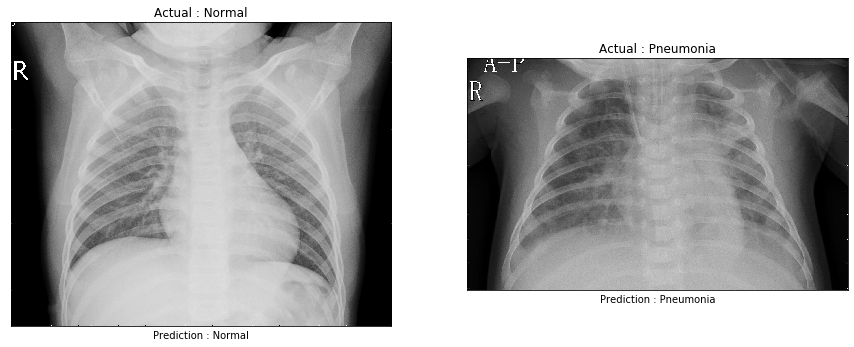

In [90]:
n = r"C:\Users\Tuhin Roy\Downloads\val\NORMAL\NORMAL2-IM-1427-0001.jpeg"
p = r"C:\Users\Tuhin Roy\Downloads\val\PNEUMONIA\person1946_bacteria_4874.jpeg"

plt.figure(1,figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(n))

if np.argmax(labels[0])==0:
    plt.title("Actual : Normal")
else:
    plt.title("Actual : Pneumonia")

if np.argmax(pred_op_check[0])==0:
    plt.xlabel("Prediction : Normal")
else:
    plt.xlabel("Prediction : Pneumonia")

plt.xticks([]) , plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(cv2.imread(p))

if np.argmax(labels[1])==0:
    plt.title("Actual : Normal")
else:
    plt.title("Actual : Pneumonia")
    
if np.argmax(pred_op_check[1])==0:
    plt.xlabel("Prediction : Normal")
else:
    plt.xlabel("Prediction : Pneumonia")
    
plt.xticks([]) , plt.yticks([])
plt.show()